# 02b – Geology Features

This notebook adds **geology-based features** by intersecting a state geology polygon layer with the grid.

**Input expected:** a geology vector file at `data/raw/state_geology.gpkg` (or a Shapefile dir `data/raw/state_geology.shp`).
Columns vary across datasets; we try to infer a unit-name column automatically.

> Tip: Use a generalized bedrock geology layer (state or regional). Smaller files run faster.


In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 02b — Geology → grid features (area-weighted one-hots, polygon-masked grid)

import os, sys, json
import numpy as np
import geopandas as gpd
import joblib
from pathlib import Path

# Add project root for src imports
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.geology import encode_geology_to_grid  # already does equal-area math
from src.data_utils import state_polygon
# grid is authoritative
GRID_PATH = project_root / "data/processed/grid_gdf.joblib"
GEO_PATHS = [
    project_root / "data/raw/state_geology.gpkg",
    project_root / "data/raw/state_geology.shp",
]

# 1) Load polygon-masked grid (authoritative length & CRS=EPSG:4326)
grid = joblib.load(GRID_PATH)
N = len(grid)
assert N > 0, "Grid is empty; run 02a_build_grid_and_coords first."
if grid.crs is None:
    grid = grid.set_crs(4326)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(4326)

# 2) Load geology vector (prefer gpkg)
geo_path = next((p for p in GEO_PATHS if os.path.exists(p)), None)
if geo_path is None:
    raise FileNotFoundError(
        "Place a geology vector file at data/raw/state_geology.gpkg (preferred) or .shp."
    )
geol = gpd.read_file(geo_path)
# Ensure CRS; encode_geology_to_grid will reproject to equal-area internally
if geol.crs is None:
    geol = geol.set_crs(4326)
elif geol.crs.to_epsg() != 4326:
    geol = geol.to_crs(4326)

# (Optional) Spatially trim geology to just the grid footprint for speed
grid_union = grid.unary_union.buffer(0)
geol_clip = gpd.clip(geol, gpd.GeoDataFrame(geometry=[grid_union], crs=4326))
print("Geology polygons within grid footprint:", len(geol_clip))

# 3) Area-weighted encoding (one-hot of top units + OTHER)
enc = encode_geology_to_grid(grid, geol_clip, unit_col=None, top_n_units=15)
X_geo = enc.features.values.astype(float)
feature_names = enc.feature_names

# 4) Persist
os.makedirs(GRID_PATH.parent, exist_ok=True)
np.save(GRID_PATH.parent / "X_geo.npy", X_geo)
with open(GRID_PATH.parent / "feature_names_geo.json", "w") as f:
    json.dump(feature_names, f)

# 5) Sanity
print("Grid rows:", N, "| X_geo rows:", X_geo.shape[0], "| cols:", X_geo.shape[1])
assert X_geo.shape[0] == N, "Row mismatch — make sure grid was built in 02a first."
print("Saved geology features to data/processed/X_geo.npy")


C:\Users\angel\AppData\Local\Temp\ipykernel_51972\2652008458.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_union = grid.unary_union.buffer(0)


Geology polygons within grid footprint: 439
Grid rows: 7646 | X_geo rows: 7646 | cols: 18
Saved geology features to data/processed/X_geo.npy


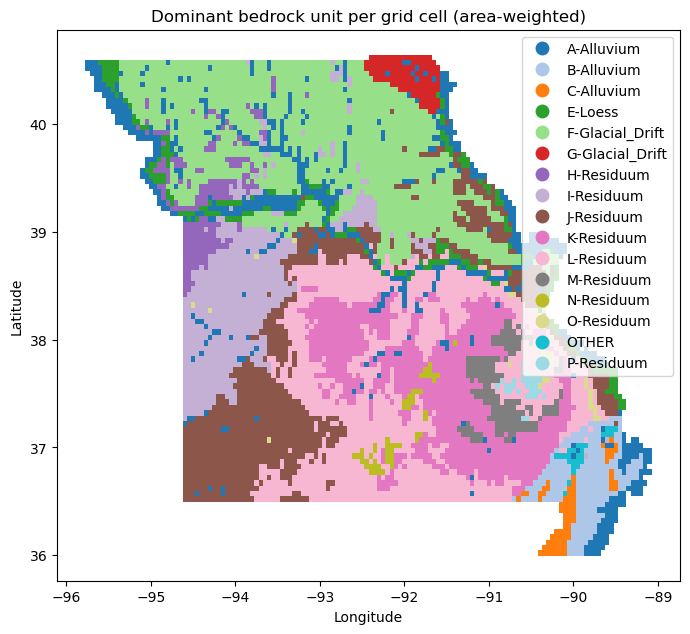

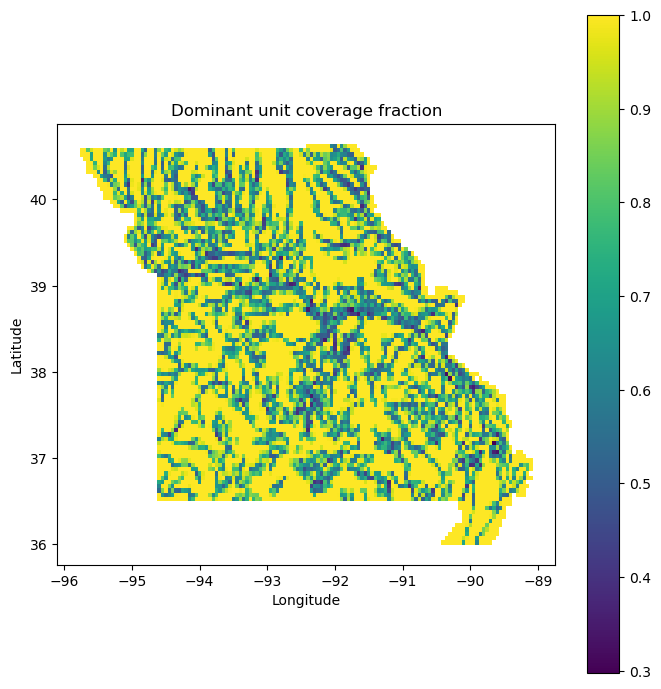

Saved geology maps → figures/geology_map_dominant.png and _domfrac.png


In [3]:
# --- Quick geology maps: dominant unit per cell + its fractional coverage ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

os.makedirs(project_root / "figures", exist_ok=True)

# 1) Dominant unit label (argmax of area-weighted one-hots)
F = np.array(feature_names)
dom_idx = X_geo.argmax(axis=1)
dom_lab = F[dom_idx]

geo_plot = grid.copy()
geo_plot["dom_unit"] = pd.Categorical(dom_lab)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
geo_plot.plot(column="dom_unit", categorical=True, legend=True, cmap="tab20", linewidth=0, ax=ax)
ax.set_title("Dominant bedrock unit per grid cell (area-weighted)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout(); plt.savefig(project_root / "figures/geology_map_dominant.png", dpi=180); plt.show()

# 2) Confidence of the dominant label (its area fraction)
geo_plot["dom_frac"] = X_geo.max(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
geo_plot.plot(column="dom_frac", cmap="viridis", legend=True, ax=ax)
ax.set_title("Dominant unit coverage fraction")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout(); plt.savefig(project_root / "figures/geology_map_domfrac.png", dpi=180); plt.show()

print("Saved geology maps → figures/geology_map_dominant.png and _domfrac.png")


Now proceed to **03_modeling_and_maps.ipynb** or **04_bayesian_logreg.ipynb** to include these features.
